In [1]:
# import pytensor
# pytensor.config.cxx = ""

In [2]:
from physiokinematic.simulate import simulate
# Generate synthetic dataset
data = simulate(1000, seed=1234)

In [4]:
data

,glong,glat,vlsr,e_vlsr,radius,true_te,te,e_te,line,e_line,...,line_freq,telescope,beam_area,Rgal,distance,log10_n,log10_q,log10_Rs,log10_em,kdar
0,196.880302,-1.265708,34.938789,1.0,50.358890,8643.992363,8643.992363,100.0,6.205795,0.1,...,8000.0,simulated,9178.029287,16.056790,8.068556,1.761276,47.971891,0.294446,4.118028,
1,15.478401,0.162145,43.683669,1.0,92.755562,5441.602048,5441.602048,100.0,18.918105,0.1,...,8000.0,simulated,9178.029287,4.695894,12.029451,1.348982,48.463444,0.733160,3.732154,
2,345.592360,0.475399,-79.657642,1.0,169.423907,4325.342307,NaN,100.0,62.107755,0.1,...,8000.0,simulated,9178.029287,3.034269,5.655855,1.554029,48.675200,0.667047,4.076135,
3,37.511379,0.062208,36.667823,1.0,120.958300,6001.782030,NaN,100.0,59.961474,0.1,...,8000.0,simulated,9178.029287,6.661902,10.911034,1.600878,49.185984,0.806076,4.308862,
4,32.696571,0.325194,0.950869,1.0,69.674392,7105.046839,NaN,100.0,9.852088,0.1,...,8000.0,simulated,9178.029287,8.226051,13.815556,1.453071,48.479189,0.669016,3.876187,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,334.920030,-0.526374,-41.669465,1.0,111.648661,4979.530926,4979.530926,100.0,34.625042,0.1,...,8000.0,simulated,9178.029287,5.826577,12.083548,1.405090,48.823048,0.815622,3.926833,
996,8.007093,-0.683600,15.995955,1.0,213.438498,5202.449344,NaN,100.0,22.980687,0.1,...,8000.0,simulated,9178.029287,5.295043,13.258754,1.174021,49.326091,1.137350,3.786421,
997,21.552789,-0.353030,115.326958,1.0,124.846023,4776.517772,4776.517772,100.0,49.841447,0.1,...,8000.0,simulated,9178.029287,3.010117,7.843606,1.539444,48.674283,0.676465,4.056383,
998,348.678912,-0.670786,-87.928605,1.0,182.303611,4397.241896,NaN,100.0,31.425082,0.1,...,8000.0,simulated,9178.029287,2.074435,6.690932,1.360072,48.601712,0.771856,3.793030,


In [5]:
from physiokinematic import NEWmodel
import importlib
importlib.reload(NEWmodel)

<module 'physiokinematic.NEWmodel' from '/home/bakko/physiokinematic/physiokinematic/NEWmodel.py'>

In [6]:
from physiokinematic.NEWmodel import model as pkmodel
# setup model
model = pkmodel(data)

/home/bakko/miniconda3/envs/physiokinematic/lib/python3.12/site-packages/pymc/model/core.py:1278: ImputationWarning: Data in te contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


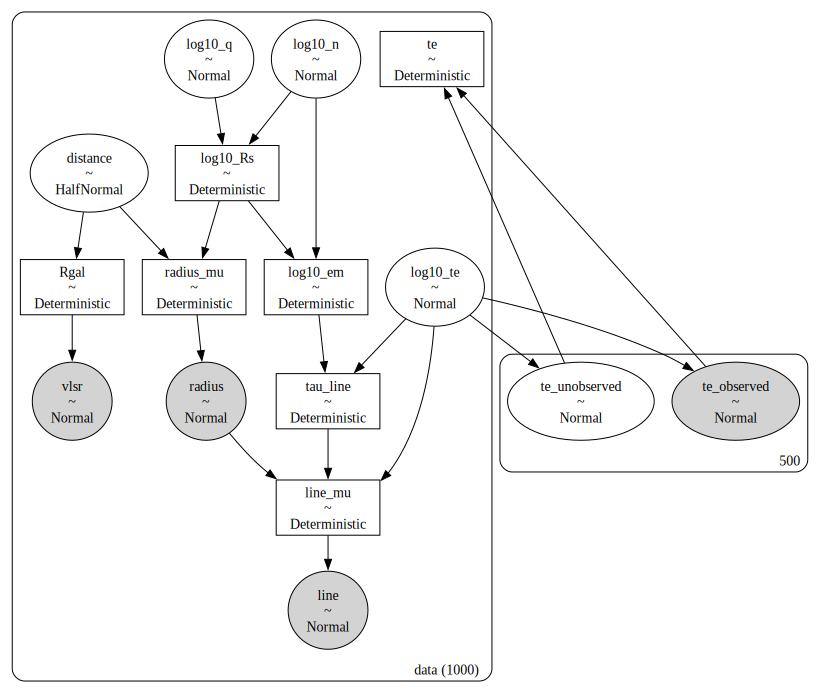

In [7]:
# visualize model
model.to_graphviz()

In [8]:
import pymc as pm

# sample prior predictive
with model:
    prior = pm.sample_prior_predictive(1000)

Sampling: [distance, line, log10_n, log10_q, log10_te, radius, te_observed, te_unobserved, vlsr]


(360.0, 0.0)

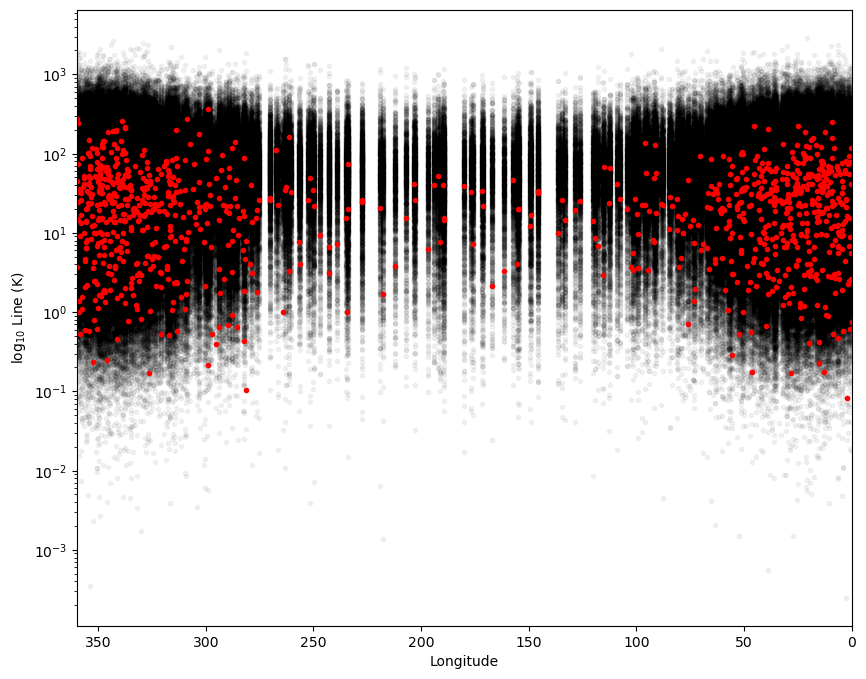

In [9]:
import matplotlib.pyplot as plt

# plot prior predictive samples
fig, ax = plt.subplots(figsize=(10, 8))
for draw in prior.prior_predictive.draw:
    ax.plot(
        data["glong"],
        prior.prior_predictive["line"].sel(chain=0, draw=draw),
        "k.",
        alpha=0.05,
    )
ax.plot(data["glong"], data["line"], "r.")
ax.set_xlabel("Longitude")
ax.set_ylabel("log$_{10}$ Line (K)")
ax.set_yscale("log")
ax.set_xlim(360.0, 0.0)

(360.0, 0.0)

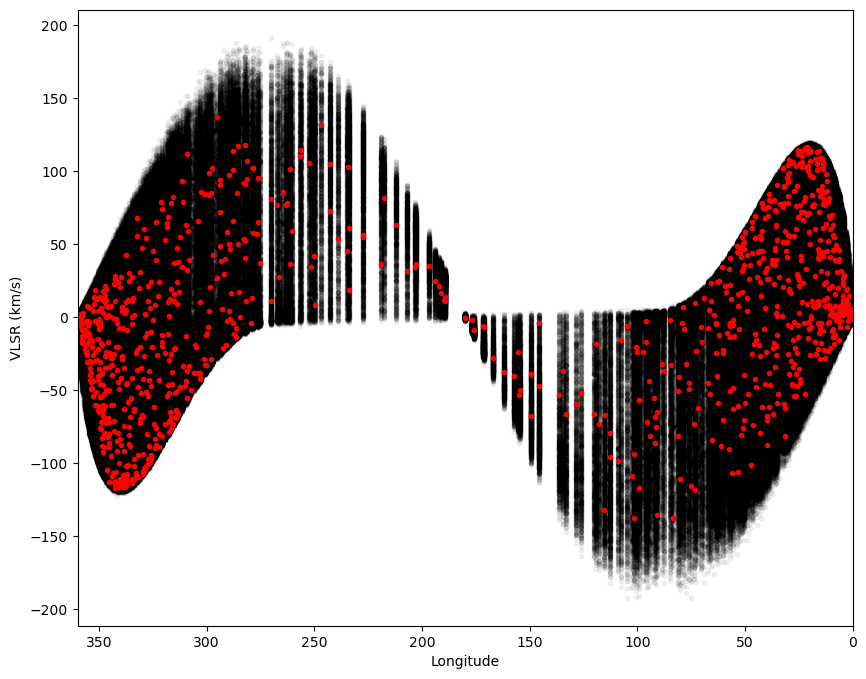

In [10]:
#Glong vs VLSR: need better priors
fig, ax = plt.subplots(figsize=(10, 8))
for draw in prior.prior_predictive.draw:
    ax.plot(
        data["glong"],
        prior.prior_predictive["vlsr"].sel(chain=0, draw=draw),
        "k.",
        alpha=0.05,
    )
ax.plot(data["glong"], data["vlsr"], "r.")
ax.set_xlabel("Longitude")
ax.set_ylabel("VLSR (km/s)")
ax.set_xlim(360.0, 0.0)


(360.0, 0.0)

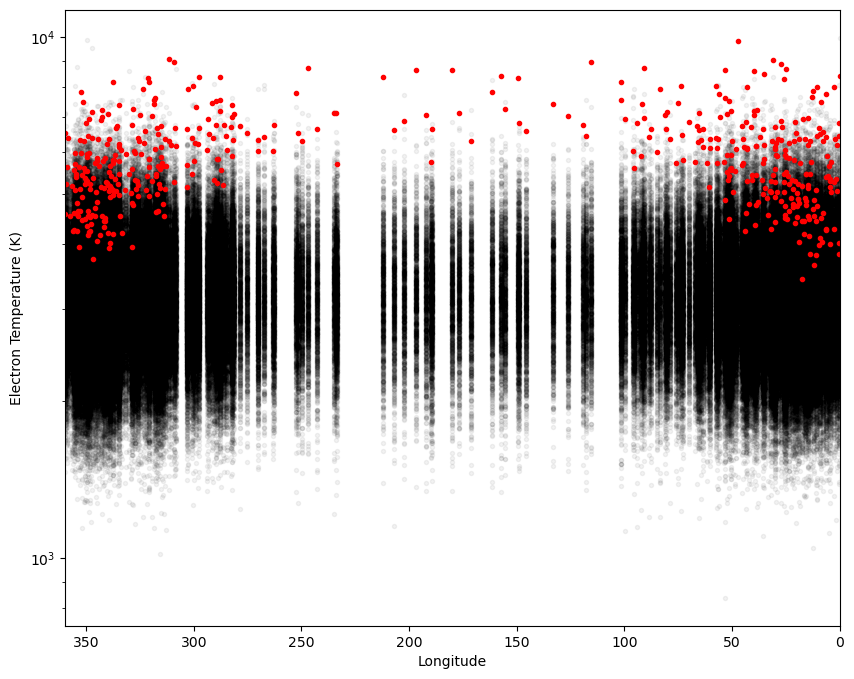

In [11]:
#Need better electron temp priors so model converges faster
fig, ax = plt.subplots(figsize=(10, 8))
for draw in prior.prior_predictive.draw:
    ax.plot(
        data.loc[~data["te"].isna(), "glong"],
        prior.prior_predictive["te_observed"].sel(chain=0, draw=draw),
        "k.",
        alpha=0.05,
    )
ax.plot(data["glong"], data["te"], "r.")
ax.set_yscale('log')
ax.set_xlabel("Longitude")
ax.set_ylabel("Electron Temperature (K)")
ax.set_xlim(360.0, 0.0)

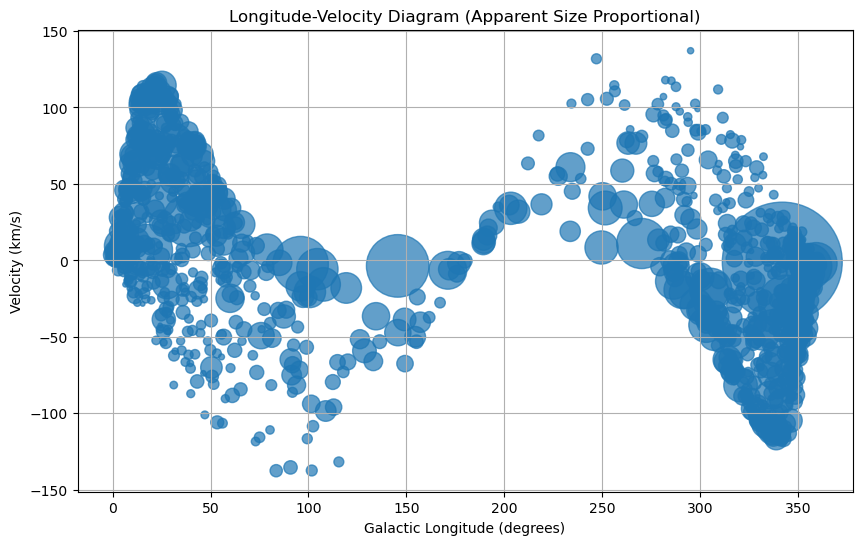

In [12]:
from physiokinematic import plot
plot.plot_longitude_velocity_diagram(data)

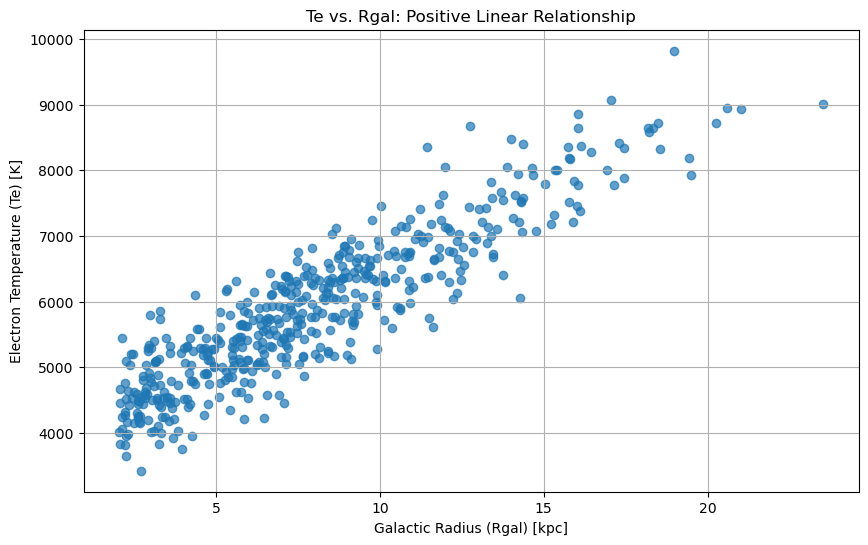

In [13]:
plot.plot_te_vs_rgal(data)

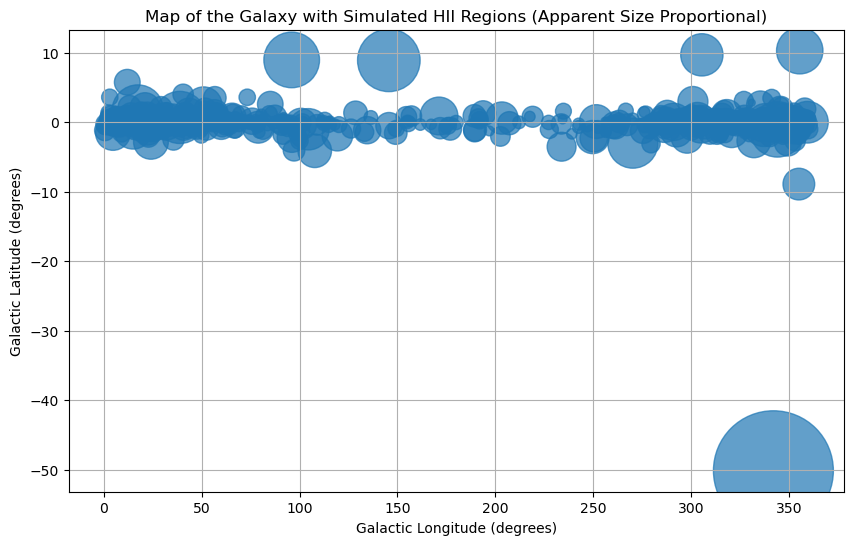

In [15]:
plot.plot_galaxy_map(data)

In [ ]:
# sample posterior- dont run on macbook. run on scylla 
with model:
    trace = pm.sample(chains=8, cores=8, tune=1000, draws=1000, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [distance, log10_te, te_unobserved, log10_q, log10_n]


Output()

In [ ]:
 pm.summary(trace)

In [ ]:
# sample posterior predictive
with model:
    posterior = pm.sample_posterior_predictive(trace.sel(draw=slice(None, None, 10)))

In [ ]:
import matplotlib.pyplot as plt

# plot prior predictive samples
fig, ax = plt.subplots(figsize=(10, 8))
for draw in posterior.posterior_predictive.draw:
    ax.plot(
        data["glong"],
        posterior.posterior_predictive["line"].sel(chain=0, draw=draw),
        "k.",
        alpha=0.05,
    )
ax.plot(data["glong"], data["line"], "r.")
ax.set_xlabel("Longitude")
ax.set_ylabel("log$_{10}$ Line (K)")
ax.set_yscale("log")
ax.set_xlim(360.0, 0.0)